In [1]:
# 对函数sinx取值的预测

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/home/wujiaocan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 定义RNN参数

HIDDEN_SIZE = 30 # LSTM中隐藏节点的个数。
NUM_LAYERS = 2   # LSTM的层数。
TIMESTEPS = 10   # 循环神经网络的训练序列长度。
TRAINING_STEPS = 10000  # 训练轮数。
BATCH_SIZE = 32         # batch大小。
TRAINING_EXAMPLES = 10000 # 训练数据个数。
TESTING_EXAMPLES = 1000   # 测试数据个数。
SAMPLE_GAP = 0.01          # 采样间隔。

In [3]:
# 产生正弦数据

def generate_data(seq):
    X = []
    y = []
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入；第i + TIMESTEPS项作为输
    # 出。即用sin函数前面的TIMESTEPS个点的信息，预测第i + TIMESTEPS个点的函数值。
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  

In [ ]:
def generate_data(seq):
    x=[]
    y=[]
    for i in range(len(seq)-TIMESTEPS):
        x.append([seq[i:i+TIMESTEPS]])
        y.append([seq[i+TIMESTEPS]])
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [4]:
def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构。
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
        for _ in range(NUM_LAYERS)])    

    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果。
    # outputs是顶层LSTM在每一步的输出结果，它的维度是[batch_size, time, HIDDEN_SIZE]，本问题中只关注最后一个时刻的输出结果。
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = outputs[:, -1, :]

    # 对LSTM网络的输出再做加一层全链接层并计算损失。注意这里默认的损失为平均
    # 平方差损失函数。
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果。
    if not is_training:
        return predictions, None, None
        
    # 计算损失函数。
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)
    return predictions, loss, train_op

In [ ]:
def lstm_model(x,y,is_training):
    cell = tf.nn.rnn_cell.MultiRNNCell(
        [tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) for _ in range(NUM_LAYERS)])
    outputs, _ = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
    output = outputs[:, -1, :]
    
    predictions = tf.contrib.layers.fully_connected(output, 1, activation_fn=None) # output是NN的输出，1是输出个数
    
    if not is_training:
        return predictions, None, None
    
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(), optimizer="Adagrad", learning_rate=0.1)
    return predictions, loss, train_op

In [5]:
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    #对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()

In [ ]:
def run_eval(sess, test_x, test_y):
    ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
    ds = ds.batch(1)
    x,y = ds.make_one_shot_iterator().get_next()
    
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(x, [0.0], False)
    
    predictions=[]
    labels=[]
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)
    
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Mean Square Error is: %f" % rmse)
    
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()

In [6]:
def train(sess, train_X, train_y):
    # 将训练数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()

    # 定义模型，得到预测结果、损失函数，和训练操作。
    with tf.variable_scope("model"):
        predictions, loss, train_op = lstm_model(X, y, True)
        
    sess.run(tf.global_variables_initializer())

    # 训练模型。
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 100 == 0:
            print("train step: " + str(i) + ", loss: " + str(l))

In [ ]:
def train(sess, train_X, train_y):
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()
    
    with tf.variable_scope("model"):
        predictions, loss, train_op = lstm_model(X,y,True)
    
    sess.run(tf.global_variables_initializer())
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 100 == 0:
            print("train_step:" + str(i) + ", loss:" + str(l))

train step: 0, loss: 0.49304086
train step: 100, loss: 0.0050050686
train step: 200, loss: 0.0039018341
train step: 300, loss: 0.0038500372
train step: 400, loss: 0.002484601
train step: 500, loss: 0.0025728315
train step: 600, loss: 0.0013323617
train step: 700, loss: 0.0017153684
train step: 800, loss: 0.0014554528
train step: 900, loss: 0.001283648
train step: 1000, loss: 0.000904711
train step: 1100, loss: 0.0008268324
train step: 1200, loss: 0.00072004396
train step: 1300, loss: 0.0006297104
train step: 1400, loss: 0.0007636411
train step: 1500, loss: 0.00058646547
train step: 1600, loss: 0.00049655733
train step: 1700, loss: 0.0004766289
train step: 1800, loss: 0.0004250009
train step: 1900, loss: 0.00036618137
train step: 2000, loss: 0.0004267209
train step: 2100, loss: 0.00021648852
train step: 2200, loss: 0.00017973996
train step: 2300, loss: 0.00019408597
train step: 2400, loss: 0.00017385371
train step: 2500, loss: 0.00013165278
train step: 2600, loss: 0.000104036044
train s

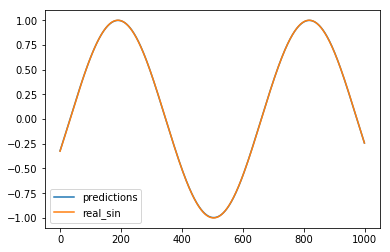

In [8]:
# 用正弦函数生成训练和测试数据集合。
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

tf.reset_default_graph()

with tf.Session() as sess:
    train(sess, train_X, train_y)
    run_eval(sess, test_X, test_y)

In [20]:
# np.linspace(0, 100.1, 10000)

In [15]:
np.sin(np.linspace(0, 100.1, 10000))

array([ 0.        ,  0.01001083,  0.02002066, ..., -0.43585399,
       -0.42682222, -0.41774768])

In [18]:
np.sin(np.linspace(0, 100.1, 10000))[:10]

array([0.        , 0.01001083, 0.02002066, 0.03002849, 0.0400333 ,
       0.05003411, 0.06002989, 0.07001967, 0.08000242, 0.08997716])

In [19]:
# np.linspace(100.1, 110.2, 1000)

In [17]:
np.sin(np.linspace(100.1, 110.2, 1000))

array([-0.41774768, -0.40854082, -0.39929219, -0.39000275, -0.38067345,
       -0.37130524, -0.36189908, -0.35245593, -0.34297675, -0.33346251,
       -0.32391419, -0.31433276, -0.3047192 , -0.29507449, -0.28539963,
       -0.27569559, -0.26596337, -0.25620397, -0.24641838, -0.23660761,
       -0.22677264, -0.2169145 , -0.20703419, -0.19713272, -0.18721109,
       -0.17727034, -0.16731146, -0.15733548, -0.14734342, -0.13733629,
       -0.12731513, -0.11728096, -0.1072348 , -0.09717768, -0.08711062,
       -0.07703467, -0.06695083, -0.05686016, -0.04676367, -0.0366624 ,
       -0.02655739, -0.01644966, -0.00634025,  0.00376981,  0.01387948,
        0.02398774,  0.03409354,  0.04419586,  0.05429366,  0.06438591,
        0.07447158,  0.08454964,  0.09461906,  0.1046788 ,  0.11472784,
        0.12476516,  0.13478973,  0.14480052,  0.1547965 ,  0.16477667,
        0.17473999,  0.18468545,  0.19461204,  0.20451873,  0.21440452,
        0.22426839,  0.23410934,  0.24392636,  0.25371845,  0.26